In [0]:
# download data (-q is the quiet mode)
! wget -q https://www.dropbox.com/s/lhb1awpi769bfdr/test.csv?dl=1 -O test.csv
! wget -q https://www.dropbox.com/s/gudb5eunj700s7j/train.csv?dl=1 -O train.csv



training 7631
testing 7632


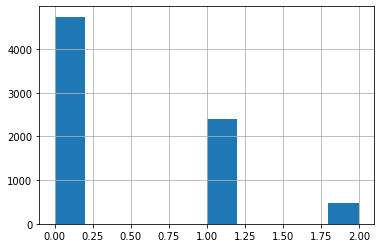

In [0]:
import pandas as pd

#Extract the data from train.csv into Xy_train
Xy_train = pd.read_csv('train.csv', engine='python')

#Stores Xy_train without the price_rating column in X_train 
X_train = Xy_train.drop(columns=['price_rating'])

#Stores Xy_train with only the price_rating column in Y_train
y_train = Xy_train[['price_rating']]

#prints the number of training data objects after 'training'
print('training', len(X_train))

#Creates a histogram for Xy_train showcasing 
#the distribution of price_rating
Xy_train.price_rating.hist()

#Extract the data from test.csv into X_test
X_test = pd.read_csv('test.csv', engine='python')

#Get the id column for X_test and store in testing_ids 
testing_ids = X_test.Id

#prints the number of testing data objects after 'testing'
print('testing', len(X_test))


In [0]:
# model training and tuning
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.svm import SVC

#Random seed ensures that the values you get in the same 
#by choosing the same random data each time.
np.random.seed(0)

#Contains the name of features which are numeric eg. have value 
#of 1.0 for bedrooms
numeric_features = ['bedrooms', 'review_scores_location', 'accommodates', 'beds']

#Pipeline: Follows steps in sequentual manner for transformation/estimator.
# Steps: Name of the step (to identify) and the transformation for each used in bracket. 
#   SimpleImputer: With strategy 'median' - replaces missing value with median for numeric_features
#   StandardScaler: Normalise data by subtracting mean 
#   and dividing by variance.

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [
  'property_type', 'is_business_travel_ready', 'room_type', ]

#   SimpleImputer: With strategy 'constant' - fills missing values with 'missing'for categorical_features
#   OneHotEncoder: Normalise data by subtracting mean. An unknown category is encountered during transform, 
#                  the resulting one-hot encoded columns for this feature will be all zeros.  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#   Applies transformers to columns of pandas DataFrame.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#eXtreme Gradient Boosting (XGB)- multi:softmax: set XGBoost to do multiclass classification using the softmax objective
#Random Number seed (seed = 1)
regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Training Data for the 7 column (numeric_features + categorical_features )
X_train = X_train[[*numeric_features, *categorical_features]]

# Testing Data for the 7 column (numeric_features + categorical_features )
X_test = X_test[[*numeric_features, *categorical_features]]

# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth':[10, 20]
}
# GridSearchCV: parameter tuning that will methodically build and 
#               evaluate a model for each combination of algorithm parameters specified in a grid.
#   cv = 5 - Cross-validation 5 times
#   n_jobs = 2 - Running two jobs in parallel
#   verbose - give messages
#   scoring - Evaluate the test set on accuracy
#scorer = metrics.make_scorer(metrics.f1_score, average = 'macro')
grid_search = GridSearchCV(
     regr, param_grid, cv=5, verbose=3, n_jobs=2, 
     scoring='accuracy')

#fitting the model with the data
grid_search.fit(X_train, y_train)
#-----------------------xx-------------------------------#

print('best score {}'.format(grid_search.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best score 0.6945360101828082


In [0]:
# Find the most interesting Classification model with High Macro F1-Score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

regr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('clf', LogisticRegression())])
clfs = []
clfs.append(LogisticRegression(max_iter=1000))
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())

scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')

for classifier in clfs:
    regr.set_params(clf = classifier)
    scores = cross_validate(regr, X_train, y_train, scoring=scorer)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------
fit_time  mean  0.6486091613769531
fit_time  std  0.015725565495908055
score_time  mean  0.00899057388305664
score_time  std  0.0003850598790412214
test_score  mean  0.6787695288564667
test_score  std  0.008974832628607118


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

---------------------------------
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
-----------------------------------
fit_time  mean  1.6730595111846924
fit_time  std  0.043744894482211874
score_time  mean  0.24873003959655762
score_time  std  0.007867383464873076
test_score  mean  0.6768627993912951
test_score  std  0.008802795967874939


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

---------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
-----------------------------------
fit_time  mean  0.02273097038269043
fit_time  std  0.001033800252984439
score_time  mean  0.42018952369689944
score_time  std  0.034223270647132945
test_score  mean  0.637128943259346
test_score  std  0.008004848905894982
---------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
-----------------------------------
fit_time  mean  0.064151

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

---------------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
-----------------------------------
fit_time  mean  2.1175632953643797
fit_time  std  0.011338316730577601
score_time  mean  0.04544267654418945
score_time  std  0.0014110137375948856
test_score  mean  0.6749810532035545
test_score  std  0.010120242750007396


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

---------------------------------
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
-----------------------------------
fit_time  mean  1.7538351535797119
fit_time  std  0.020291353051022355
score_time  mean  0.021356201171875
score_time  std  0.0001953758778598468
test_score  mean  0.6830634244284595
test_score  std  0.010979827337529887


In [0]:
# Random Forest Model
# Use Randomized Search CV to find the ranges of parameters to look into

from sklearn.ensemble import RandomForestClassifier
regr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('clf', RandomForestClassifier())])

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

scorer = metrics.make_scorer(metrics.f1_score, average = 'macro')

random_grid = {'clf__n_estimators': n_estimators,
               'clf__max_features': max_features,
               'clf__max_depth': max_depth,
               'clf__min_samples_split': min_samples_split,
               'clf__min_samples_leaf': min_samples_leaf,
               'clf__bootstrap': bootstrap}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('clf', RandomForestClassifier())])

rf_random = RandomizedSearchCV(regr, random_grid, cv = 5, verbose=2, random_state=42, scoring=scorer)

rf_random.fit(X_train, y_train)

print(rf_random.best_params_) #{'clf__n_estimators': 1909, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 90, 'clf__bootstrap': False}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=  26.4s
[CV] clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=  25.4s
[CV] clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=  26.6s
[CV] clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=  25.8s
[CV] clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1927, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=  26.1s
[CV] clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True, total=   9.9s
[CV] clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True, total=   9.6s
[CV] clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True, total=   9.9s
[CV] clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True, total=  10.0s
[CV] clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1290, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=True, total=   9.9s
[CV] clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False, total=  21.3s
[CV] clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False, total=  20.4s
[CV] clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False, total=  22.0s
[CV] clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False, total=  21.1s
[CV] clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1254, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=False, total=  21.3s
[CV] clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True, total=  23.8s
[CV] clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True, total=  23.3s
[CV] clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True, total=  23.8s
[CV] clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True, total=  23.3s
[CV] clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1727, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=70, clf__bootstrap=True, total=  23.2s
[CV] clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True, total=  13.7s
[CV] clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True, total=  13.0s
[CV] clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True, total=  13.6s
[CV] clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True, total=  13.7s
[CV] clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1381, clf__min_samples_split=10, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=40, clf__bootstrap=True, total=  13.8s
[CV] clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True, total=  11.2s
[CV] clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True, total=  10.5s
[CV] clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True, total=  11.0s
[CV] clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True, total=  10.8s
[CV] clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1109, clf__min_samples_split=2, clf__min_samples_leaf=4, clf__max_features=auto, clf__max_depth=100, clf__bootstrap=True, total=  10.7s
[CV] clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False, total=  44.0s
[CV] clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False, total=  44.0s
[CV] clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False, total=  44.6s
[CV] clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False, total=  44.3s
[CV] clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1909, clf__min_samples_split=10, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=False, total=  44.4s
[CV] clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False, total=  12.8s
[CV] clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False, total=  12.3s
[CV] clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False, total=  13.1s
[CV] clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False, total=  12.5s
[CV] clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1327, clf__min_samples_split=2, clf__min_samples_leaf=2, clf__max_features=auto, clf__max_depth=10, clf__bootstrap=False, total=  12.7s
[CV] clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=   6.2s
[CV] clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=   5.8s
[CV] clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=   6.4s
[CV] clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=   6.4s
[CV] clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=618, clf__min_samples_split=5, clf__min_samples_leaf=4, clf__max_features=sqrt, clf__max_depth=90, clf__bootstrap=True, total=   6.3s
[CV] clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False, total=  30.3s
[CV] clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False, total=  28.7s
[CV] clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False, total=  30.1s
[CV] clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False, total=  29.5s
[CV] clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False 


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__n_estimators=1836, clf__min_samples_split=10, clf__min_samples_leaf=2, clf__max_features=sqrt, clf__max_depth=110, clf__bootstrap=False, total=  29.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 16.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


{'clf__n_estimators': 1909, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 90, 'clf__bootstrap': False}


In [0]:
# Based on Random Search, Use GridSearchCV to Hypertune the parameters for Random Forest

from sklearn.ensemble import RandomForestClassifier
regr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('clf', RandomForestClassifier())])

scorer = metrics.make_scorer(metrics.f1_score, average = 'macro')

param_grid = {'clf__n_estimators': [1850,1900,1950,2000],
               'clf__max_depth': [70,80,90,100],
               'clf__min_samples_split': [8,10,12,14],
               'clf__min_samples_leaf': [1,2,3],
              'clf__bootstrap': [False],
              'clf__max_features':['sqrt']}


grid_search_RF = GridSearchCV(regr, param_grid, cv=2, verbose=3, n_jobs=2, 
      scoring=scorer)

grid_search_RF.fit(X_train, y_train)

print('best score Random Forest {}'.format(grid_search_RF.best_score_)) # best score Random Forest 0.5086073645537579
print('best parameter Random Forest {}'.format(grid_search_RF.best_params_)) # Random Forest {'clf__bootstrap': False, 'clf__max_depth': 80, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 2000}

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 31.4min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 67.1min
[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed: 90.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


best score Random Forest 0.5086073645537579
best parameter Random Forest {'clf__bootstrap': False, 'clf__max_depth': 80, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 2000}


In [0]:
# Logistic Regression
# Use Randomized Search CV to find the ranges of parameters to look into

from sklearn.model_selection import RandomizedSearchCV

regr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('clf', LogisticRegression(max_iter=1000))])
C_range = np.random.normal(1, 0.2, 10).astype(float)
 
# Check that C>0 
C_range[C_range < 0] = 0.0001

random_grid = {'clf__penalty': ['l1', 'l2'],
                    'clf__C': C_range}

scorer = metrics.make_scorer(metrics.f1_score, average = 'macro')

lr_random = RandomizedSearchCV(regr, random_grid, cv = 5, verbose=2, random_state=42, scoring=scorer)

lr_random.fit(X_train, y_train)

print('best parameter from Random Logistic Regression {}'.format(lr_random.best_params_)) #'best parameter from Random Logistic Regression {'clf__solver': 'saga', 'clf__penalty': 'l1', 'clf__class_weight': {1: 0.6, 0: 0.4}, 'clf__C': 0.985298251912561}




Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] clf__penalty=l1, clf__C=1.1353684129336936 ......................
[CV] ....... clf__penalty=l1, clf__C=1.1353684129336936, total=   0.0s
[CV] clf__penalty=l1, clf__C=1.1353684129336936 ......................
[CV] ....... clf__penalty=l1, clf__C=1.1353684129336936, total=   0.0s
[CV] clf__penalty=l1, clf__C=1.1353684129336936 ......................
[CV] ....... clf__penalty=l1, clf__C=1.1353684129336936, total=   0.0s
[CV] clf__penalty=l1, clf__C=1.1353684129336936 ......................
[CV] ....... clf__penalty=l1, clf__C=1.1353684129336936, total=   0.0s
[CV] clf__penalty=l1, clf__C=1.1353684129336936 ......................
[CV] ....... clf__penalty=l1, clf__C=1.1353684129336936, total=   0.0s
[CV] clf__penalty=l2, clf__C=0.942207818041415 .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] ........ clf__penalty=l2, clf__C=0.942207818041415, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.942207818041415 .......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ clf__penalty=l2, clf__C=0.942207818041415, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.942207818041415 .......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ clf__penalty=l2, clf__C=0.942207818041415, total=   0.8s
[CV] clf__penalty=l2, clf__C=0.942207818041415 .......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ clf__penalty=l2, clf__C=0.942207818041415, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.942207818041415 .......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ clf__penalty=l2, clf__C=0.942207818041415, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.9206858479000788 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9206858479000788, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.9206858479000788 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9206858479000788, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.9206858479000788 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9206858479000788, total=   0.8s
[CV] clf__penalty=l2, clf__C=0.9206858479000788 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9206858479000788, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.9206858479000788 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9206858479000788, total=   0.7s
[CV] clf__penalty=l2, clf__C=1.1353684129336936 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=1.1353684129336936, total=   0.8s
[CV] clf__penalty=l2, clf__C=1.1353684129336936 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=1.1353684129336936, total=   0.7s
[CV] clf__penalty=l2, clf__C=1.1353684129336936 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=1.1353684129336936, total=   0.7s
[CV] clf__penalty=l2, clf__C=1.1353684129336936 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=1.1353684129336936, total=   0.7s
[CV] clf__penalty=l2, clf__C=1.1353684129336936 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=1.1353684129336936, total=   0.7s
[CV] clf__penalty=l1, clf__C=0.6750381308670478 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6750381308670478, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.6750381308670478 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6750381308670478, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.6750381308670478 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6750381308670478, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.6750381308670478 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6750381308670478, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.6750381308670478 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6750381308670478, total=   0.0s
[CV] clf__penalty=l2, clf__C=0.9342038348928312 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

[CV] ....... clf__penalty=l2, clf__C=0.9342038348928312, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.9342038348928312 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9342038348928312, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.9342038348928312 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9342038348928312, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.9342038348928312 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9342038348928312, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.9342038348928312 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.9342038348928312, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.6315661145806624 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6315661145806624, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.6315661145806624 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6315661145806624, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.6315661145806624 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6315661145806624, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.6315661145806624 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6315661145806624, total=   0.5s
[CV] clf__penalty=l2, clf__C=0.6315661145806624 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6315661145806624, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.6547738441771991 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6547738441771991, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.6547738441771991 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6547738441771991, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.6547738441771991 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6547738441771991, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.6547738441771991 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6547738441771991, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.6547738441771991 ......................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... clf__penalty=l2, clf__C=0.6547738441771991, total=   0.6s
[CV] clf__penalty=l1, clf__C=0.6538978100100528 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6538978100100528, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.6538978100100528 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6538978100100528, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.6538978100100528 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6538978100100528, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.6538978100100528 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6538978100100528, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.6538978100100528 ......................
[CV] ....... clf__penalty=l1, clf__C=0.6538978100100528, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.942207818041415 .......................
[CV] ........ clf__penalty=l1, clf__C=0.942207818041415, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.942207818041415 .......................
[CV] .

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

[CV] ........ clf__penalty=l1, clf__C=0.942207818041415, total=   0.0s
[CV] clf__penalty=l1, clf__C=0.942207818041415 .......................
[CV] ........ clf__penalty=l1, clf__C=0.942207818041415, total=   0.0s
best parameter from Random Logistic Regression {'clf__penalty': 'l2', 'clf__C': 0.942207818041415}


In [0]:
# Based on Random Search, Use GridSearchCV to Hypertune the parameters for Logistic Regression

regr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('clf', LogisticRegression(max_iter=2000))])

param_grid = {'clf__penalty': ['l2'], 
                    'clf__C': [0.940,9.845,0.948,0.949,0.950,0.96, 0.955, 0.959, 0.953, 0.961]}


grid_search_LN = GridSearchCV(regr, param_grid, cv=5, verbose=3, n_jobs=2, 
      scoring=scorer)

grid_search_LN.fit(X_train, y_train)

print('best score Logistic Regression {}'.format(grid_search_LN.best_score_)) # best score Logistic Regression 0.6791832396336316
print('best parameter Logistic Regression {}'.format(grid_search_LN.best_params_)) # best parameter Logistic Regression {'clf__C': 0.845, 'clf__penalty': 'l2'}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   33.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best score Logistic Regression 0.5005623339363809
best parameter Logistic Regression {'clf__C': 9.845, 'clf__penalty': 'l2'}


In [0]:
# Choose LN as it has a higher f1 score with the hyper-tuning.
# Prediction & generating the submission file
y_pred = grid_search_RF.predict(X_test) #PUBLIC LEADERSHIP: 0.71069    PRIVATE LEADERSHIP: 0.70125
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_pred}).to_csv('sample_submission.csv', index=False)
print("---Done---")

---Done---
